<div class="alert-info" style="padding: 20px; border-radius: 10px">  
    
# Проект: Предсказание снижения покупательской активности

## Цель проекта
Разработать модель машинного обучения для предсказания вероятности снижения покупательской активности на основе данных о поведении покупателей интернет-магазина. На основе этой модели выделить сегмент покупателей, предложить рекомендации для увеличения их покупательской активности и повысить прибыльность компании. 

Основные критерии: 
- Точность модели в предсказании снижения активности
- Значимость признаков, которые влияют на это снижение
- Эффективность предложенных рекомендаций по работе с выбранным сегментом

## План проведения работы

1. **Загрузка, изучение и предобработка данных**
   - Импортирование необходимых библиотек.
   - Загрузка данных из файлов `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`.
   - Преобразование данных, обработка пропусков, аномалий и приведение данных к нужному формату.

2. **Исследовательский анализ данных**
   - Проведение статистического анализа данных из каждой таблицы.
   - Отбор клиентов с покупательской активностью не менее трёх месяцев.
   - Построение графиков и визуализация ключевых показателей.

3. **Объединение таблиц**
   - Объединение данных из всех таблиц в одну итоговую таблицу.
   - Создание отдельных столбцов для данных о выручке и времени на сайте за каждый период.

4. **Корреляционный анализ**
   - Расчет коэффициентов корреляции между признаками.
   - Построение корреляционной матрицы и диаграммы "рассеяния".
   - Устранение признаков с высокой мультиколлинеарностью.

5. **Использование пайплайнов для обучения моделей**
   - Разработка пайплайнов для подготовки данных и обучения моделей.
   - Обучение четырёх моделей: `KNeighborsClassifier`, `DecisionTreeClassifier`, `LogisticRegression` и `SVC`.
   - Подбор гиперпараметров и выбор лучшей модели на основе заданной метрики.

6. **Анализ важности признаков**
   - Оценка важности признаков для лучшей модели с использованием метода SHAP.
   - Построение графика важности признаков.
   - Выводы о значимости признаков и их влиянии на целевой признак.

7. **Сегментация покупателей и рекомендации**
   - Сегментация покупателей на основе результатов моделирования и данных о прибыльности.
   - Графический и аналитический анализ выбранного сегмента.
   - Разработка предложений по увеличению покупательской активности в выделенном сегменте.

8. **Итоговый вывод**
   - Описание задачи, исходных данных и проведённой предобработки.
   - Выбор и обучение лучшей модели.
   - Рекомендации и выводы по работе с выбранным сегментом для повышения его покупательской активности и прибыльности компании.

</div>

Ссылка на репозиторий: [SL_project](https://github.com/Radigos-X/SL_project)

## Загрузка данных

In [1]:
!pip install phik -q
!pip install shap -q
!pip install --upgrade scikit-learn==1.3.0 -q

In [ ]:
import pandas as pd
import seaborn as sns
import phik
import shap
import matplotlib.pyplot as plt
import numpy as np

from phik import phik_matrix
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     RandomizedSearchCV
                                    )

from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             roc_auc_score,
                             roc_curve, 
                             auc
                            )


from sklearn.preprocessing import (MinMaxScaler,
                                   OneHotEncoder, 
                                   OrdinalEncoder, 
                                   RobustScaler,
                                   StandardScaler, 
                                   LabelEncoder
                                  )

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';')

In [4]:
display(market_file.head(), market_file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


None

In [5]:
display(market_money.head(), market_money.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


None

In [6]:
display(market_time.head(), market_time.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


None

In [7]:
display(money.head(), money.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


None

<div class="alert alert-info"> 
При загрузке данных использовался параметр sep=';' для разделение столбцов и данных в некоторых датафреймах. После в данных были замечены некорректные значения: "стандартт", а должно быть "стандарт"; "предыдцщий_месяц", а должно быть "предыдущий_месяц". Так же не целые значения были записаны некорректным образом и имели тип данных object.

- Были установлены необходимые пакеты
- Были импортированы нужные библиотеки, конкретные классы и модели
- Датасеты были успешно загружены в market_file, market_time, money
</div>

## Предобработка данных

In [ ]:
market_file.columns = market_file.columns.str.replace(' ', '_')
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].replace('стандартт', 'стандарт')
market_file[['Акционные_покупки', 'Маркет_актив_6_мес']] = market_file[['Акционные_покупки', 'Маркет_актив_6_мес']].astype(float)
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [ ]:
market_money['Выручка'] = market_money['Выручка'].astype(float)
market_money = market_money.drop_duplicates().reset_index(drop=True)

market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
money['Прибыль'] = money['Прибыль'].str.replace(',', '.').astype(float)

In [10]:
# Проверка пропущенных значений
print(market_file.isna().sum())
print()
print(market_money.isna().sum())
print()
print(market_time.isna().sum())
print()
print(money.isna().sum())

id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

id         0
Период     0
Выручка    0
dtype: int64

id        0
Период    0
минут     0
dtype: int64

id         0
Прибыль    0
dtype: int64


<div class="alert alert-info"> 
Пропусков в данных нет.

Пробелы в названиях столбцов заменены на подчеркивания.

Исправлены ошибки и типы данных в market_file и market_money, удалены дубликаты. Исправлены опечатки в market_time.
</div>

## Исследовательский анализ данных

In [11]:
display(market_file.describe())
display(market_money.describe())
display(market_time.describe())
display(money.describe())

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


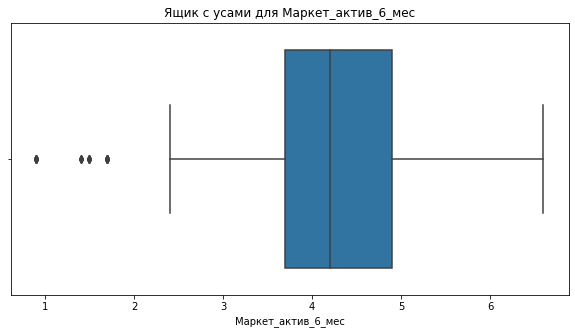

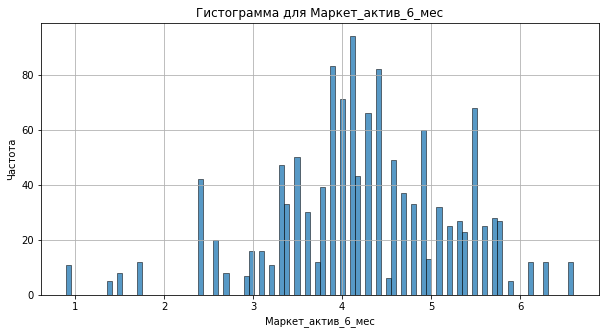

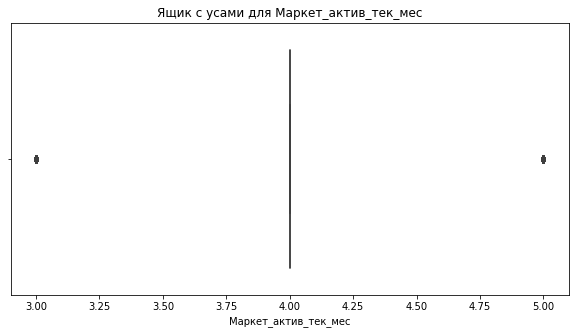

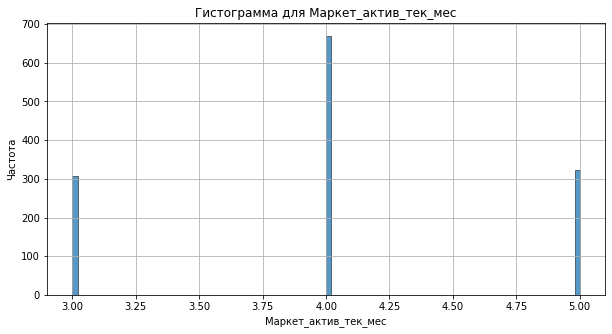

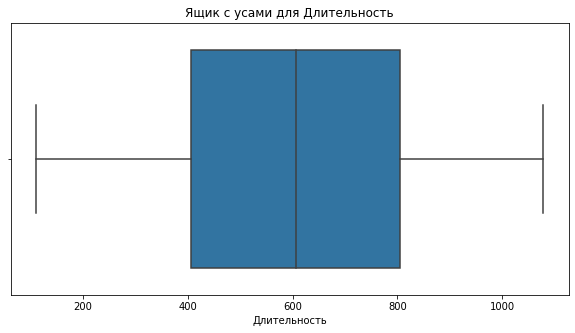

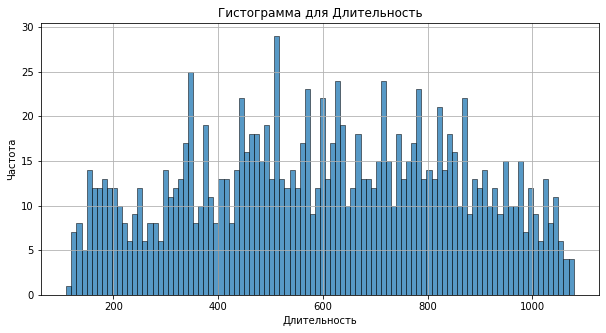

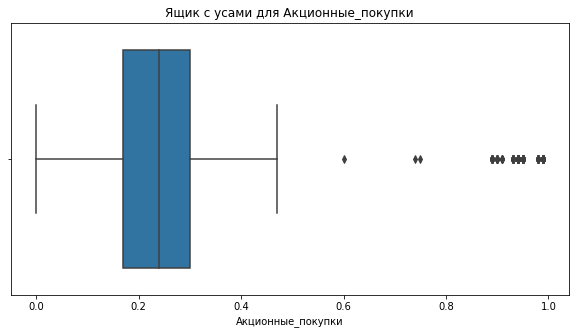

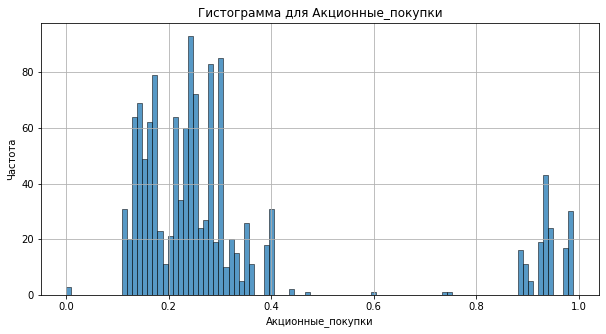

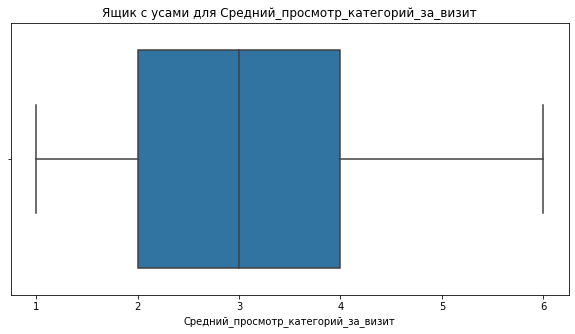

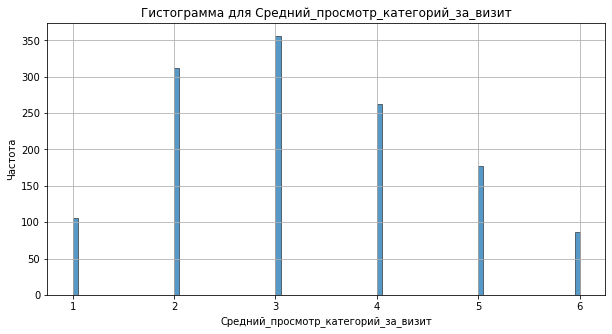

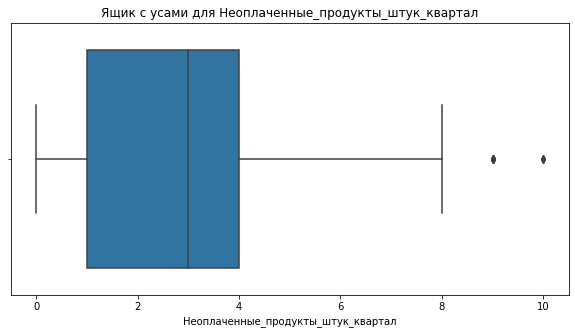

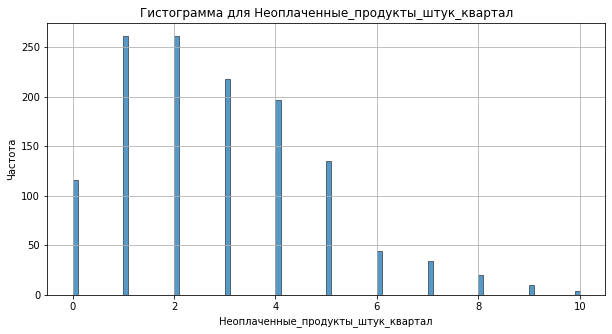

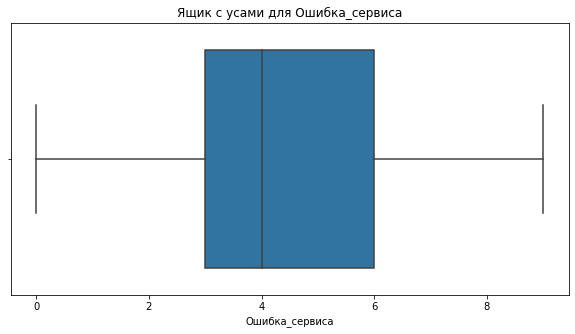

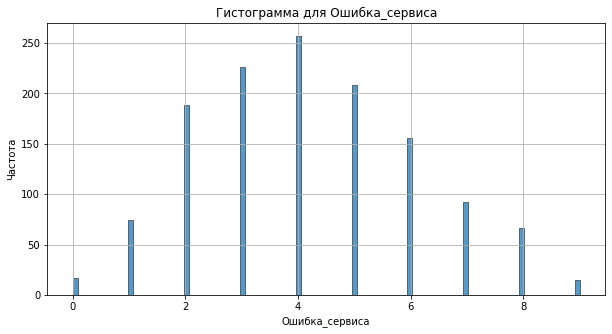

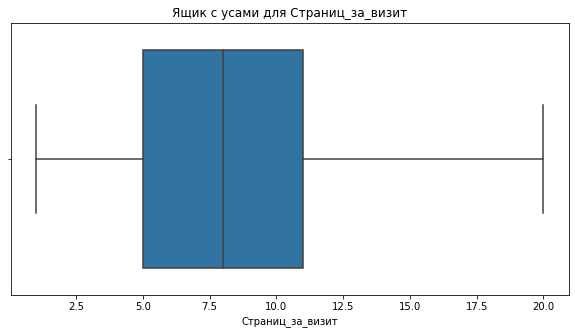

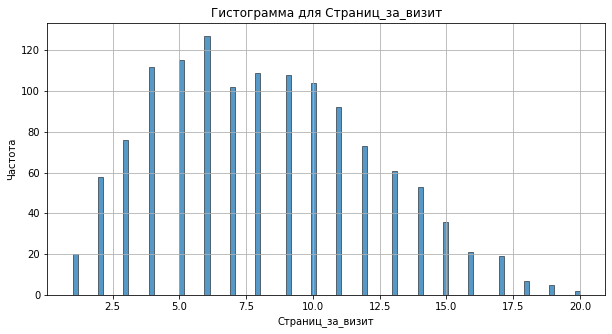

In [ ]:
# Разделим признаки на дискретные и непрерывные
discrete_features = ['Средний_просмотр_категорий_за_визит', 'Маркет_актив_тек_мес', 
                     'Ошибка_сервиса', 'Страниц_за_визит', 'Неоплаченные_продукты_штук_квартал']  
continuous_features = ['Длительность', 'Акционные_покупки', 'Маркет_актив_6_мес'] 

# Для дискретных признаков используем countplot
for feature in discrete_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=market_file[feature])
    plt.title(f'Распределение для {feature}')
    plt.xlabel(feature)
    plt.grid(True)
    plt.show()

for feature in continuous_features:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(market_file[feature], fill=True)
    plt.title(f'Плотность распределения для {feature}')
    plt.xlabel(feature)
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.histplot(market_file[feature], bins=80)
    plt.title(f'Гистограмма для {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

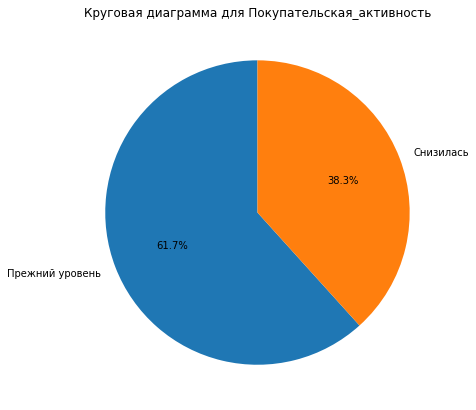

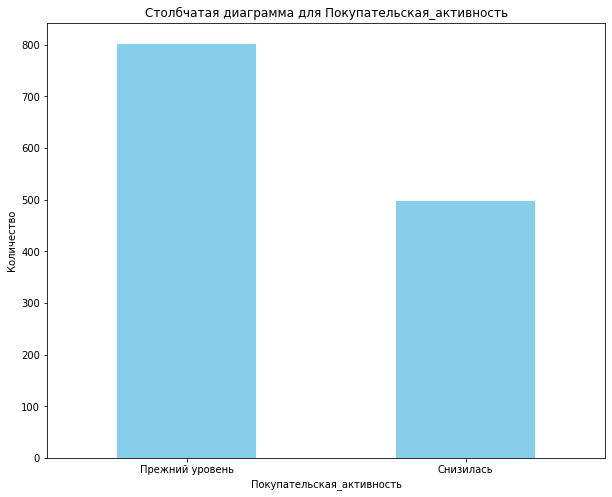

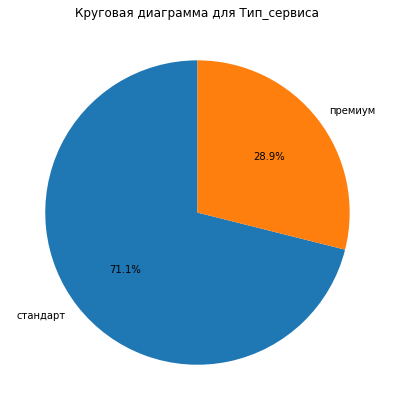

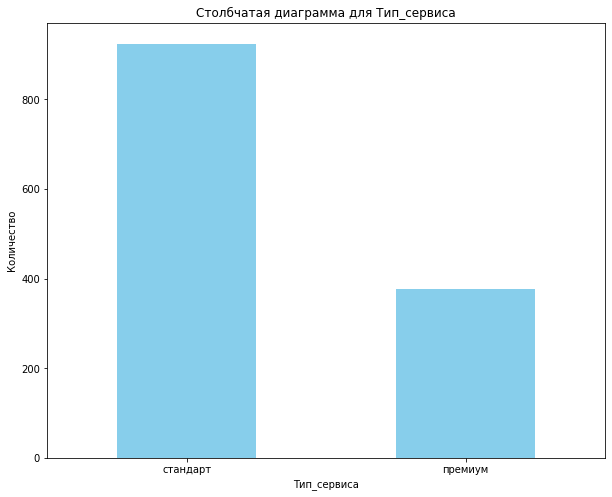

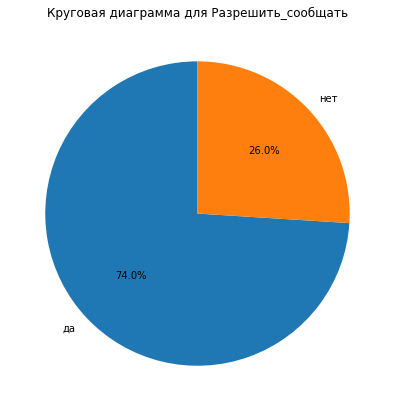

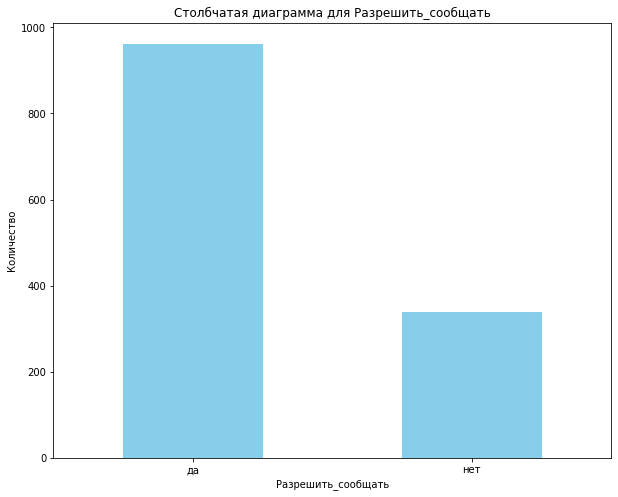

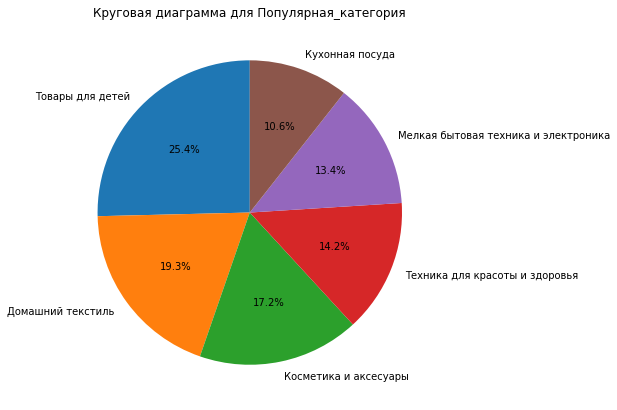

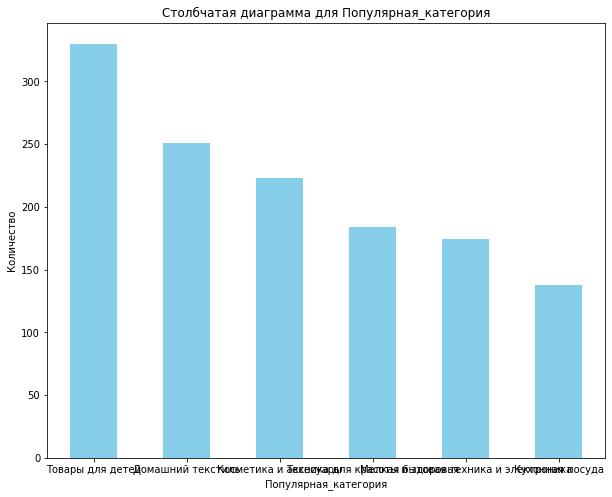

In [ ]:
mf_cat_features = ['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']

for feature in mf_cat_features:
    plt.figure(figsize=(10, 7))
    market_file[feature].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title(f'Круговая диаграмма для {feature}')
    plt.ylabel('')  
    plt.show()

    plt.figure(figsize=(10, 8))
    market_file[feature].value_counts().plot.bar(color='skyblue')
    plt.title(f'Столбчатая диаграмма для {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    plt.show()

In [ ]:
# Удаляем строки, где выручка равна 0
zero_revenue_ids = market_money.loc[market_money['Выручка'] == 0, 'id'].unique()
market_money = market_money.loc[~market_money['id'].isin(zero_revenue_ids)]

print(market_money.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3894 entries, 0 to 3893
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3894 non-null   int64  
 1   Период   3894 non-null   object 
 2   Выручка  3894 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.4+ KB
None


In [ ]:
market_money['Выручка'] = market_money['Выручка'].replace(market_money['Выручка'].max(), market_money['Выручка'].median())

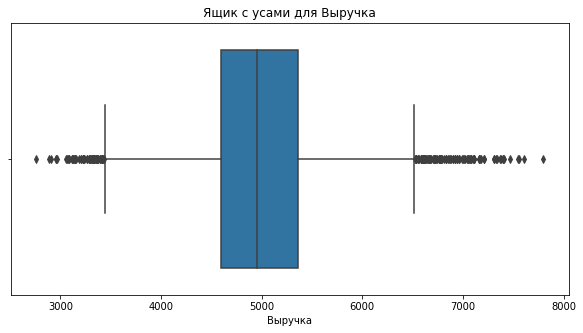

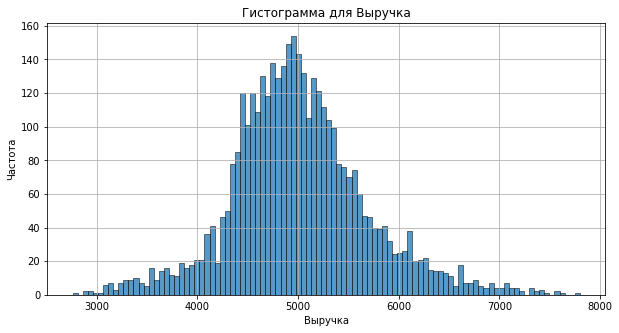

In [ ]:
market_money['Выручка'] = market_money['Выручка'].replace(market_money['Выручка'].max(), market_money['Выручка'].median())

mm_features = ['Выручка']

for feature in mm_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=market_money[feature])
    plt.title(f'Ящик с усами для {feature}')
    plt.xlabel(feature)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.histplot(market_money[feature], bins=70)
    plt.title(f'Гистограмма для {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

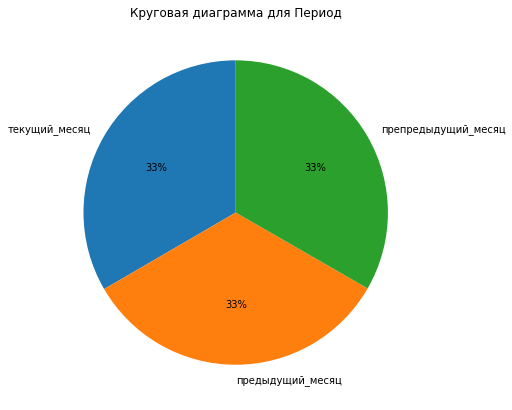

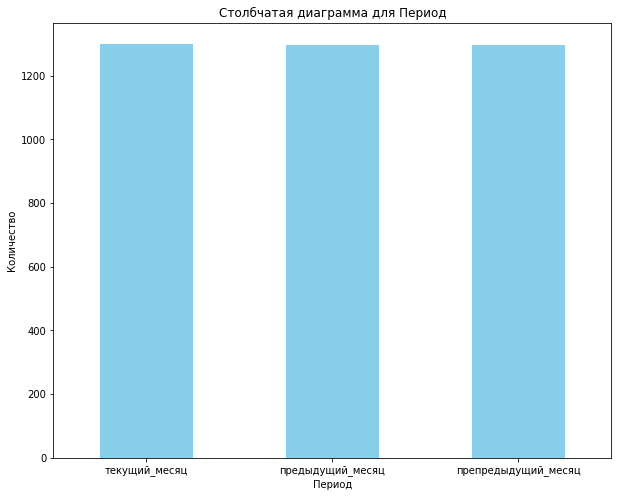

In [ ]:
mm_cat_features = ['Период']

for feature in mm_cat_features:
    plt.figure(figsize=(10, 7))
    market_money[feature].value_counts().plot.pie(autopct='%1.0f%%', startangle=90)
    plt.title(f'Круговая диаграмма для {feature}')
    plt.ylabel('')  
    plt.show()

    plt.figure(figsize=(10, 8))
    market_money[feature].value_counts().plot.bar(color='skyblue')
    plt.title(f'Столбчатая диаграмма для {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    plt.show()

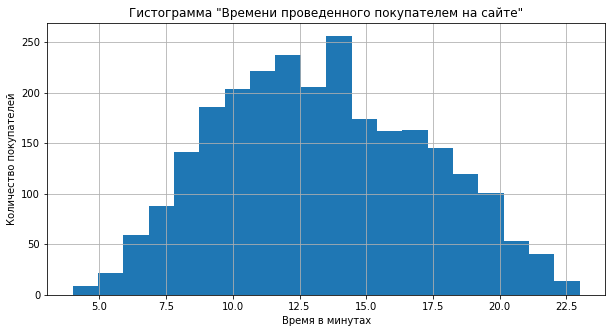

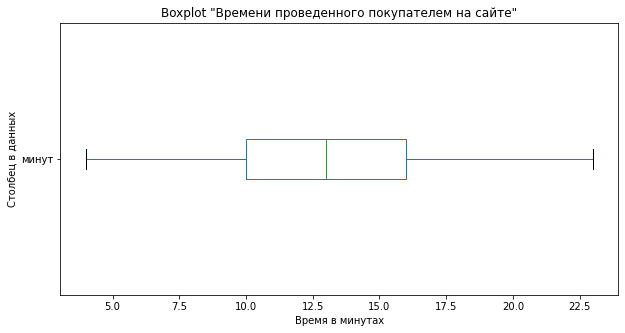

In [ ]:
# Гистограмма
plt.figure(figsize=(10, 5))
market_time['минут'].plot(kind='hist', bins=20, grid=True)
plt.title('Гистограмма "Времени проведенного покупателем на сайте"')
plt.xlabel('Время в минутах')
plt.ylabel('Количество покупателей')
plt.show()

# Boxplot
plt.figure(figsize=(10, 5))
market_time['минут'].plot(kind='box', vert=False)
plt.title('Boxplot "Времени проведенного покупателем на сайте"')
plt.xlabel('Время в минутах')
plt.ylabel('Столбец в данных')
plt.show()

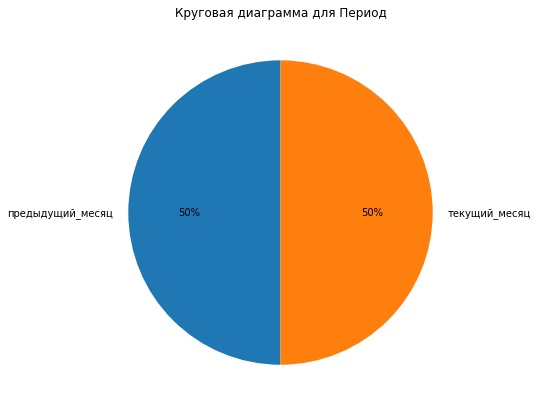

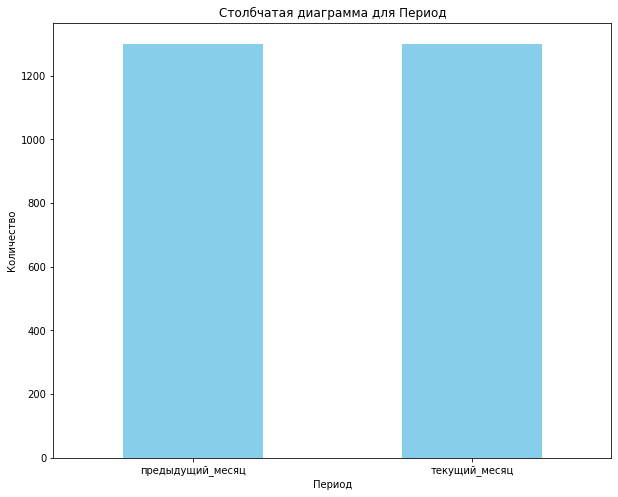

In [ ]:
mt_cat_features = ['Период']

for feature in mt_cat_features:
    plt.figure(figsize=(10, 7))
    market_time[feature].value_counts().plot.pie(autopct='%1.0f%%', startangle=90)
    plt.title(f'Круговая диаграмма для {feature}')
    plt.ylabel('')  
    plt.show()

    plt.figure(figsize=(10, 8))
    market_time[feature].value_counts().plot.bar(color='skyblue')
    plt.title(f'Столбчатая диаграмма для {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    plt.show()

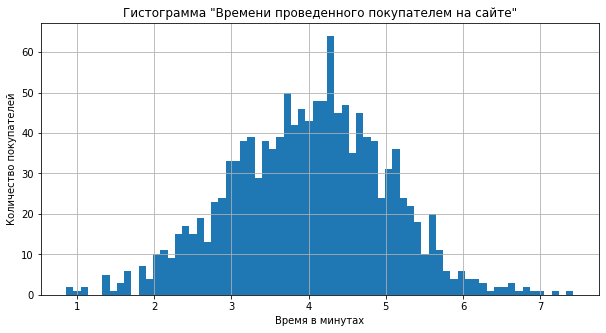

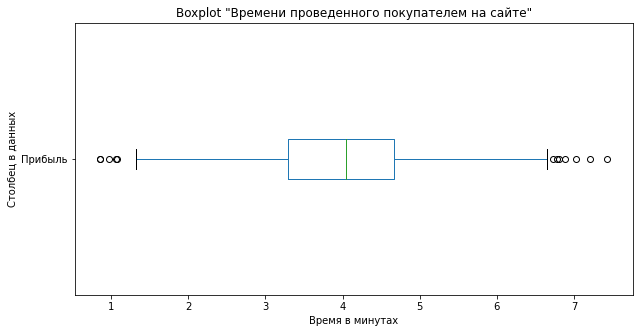

In [ ]:
# Гистограмма
plt.figure(figsize=(10, 5))
money['Прибыль'].plot(kind='hist', bins=70, grid=True)
plt.title('Гистограмма "Времени проведенного покупателем на сайте"')
plt.xlabel('Время в минутах')
plt.ylabel('Количество покупателей')
plt.show()

# Boxplot
plt.figure(figsize=(10, 5))
money['Прибыль'].plot(kind='box', vert=False)
plt.title('Boxplot "Времени проведенного покупателем на сайте"')
plt.xlabel('Время в минутах')
plt.ylabel('Столбец в данных')
plt.show()

<div class="alert alert-info">
Данные в основном распределены нормально, но в большинстве столбцов есть выбросы.

Столбцы период в таблицах market_money и market_time имеют одинаковые названия, но разную значимость, что важно учитывать при объединении таблиц.

Выбраны активные пользователи, совершавшие покупки каждый из последних 3 месяцев.
</div>

## Объединение таблиц

In [ ]:
df_prev = market_time[market_time['Период']=='предыдущий_месяц'].copy()
df_prev.rename(columns={'минут':'Минут_предыдущего_месяца'}, inplace=True)
df_prev.drop('Период', axis= 1 , inplace= True )

df_curr = market_time[market_time['Период']=='текущий_месяц'].copy()
df_curr.rename(columns={'минут':'Минут_текущего_месяца'}, inplace=True)
df_curr.drop('Период', axis= 1 , inplace= True )

df_market_time = df_prev.merge(df_curr, on='id', sort=True)

display(df_market_time.head(), df_market_time.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   id                        1300 non-null   int64
 1   Минут_предыдущего_месяца  1300 non-null   int64
 2   Минут_текущего_месяца     1300 non-null   int64
dtypes: int64(3)
memory usage: 40.6 KB


,id,Минут_предыдущего_месяца,Минут_текущего_месяца
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


None

In [ ]:
df_curr_2 = market_money[market_money['Период']=='предыдущий_месяц'].copy()
df_curr_2.rename(columns={'Выручка':'Выручка_текущего_месяца'}, inplace=True)
df_curr_2.drop('Период', axis= 1 , inplace= True )

df_prev_2 = market_money[market_money['Период']=='текущий_месяц'].copy()
df_prev_2.rename(columns={'Выручка':'Выручка_предыдущего_месяца'}, inplace=True)
df_prev_2.drop('Период', axis= 1 , inplace= True )

df_b_prev = market_money[market_money['Период']=='препредыдущий_месяц'].copy()
df_b_prev.rename(columns={'Выручка':'Выручка_препредыдущего_месяца'}, inplace=True)
df_b_prev.drop('Период', axis= 1 , inplace= True )

df_market_money = df_curr_2.merge(df_prev_2, on='id', sort=True)
df_market_money = df_b_prev.merge(df_market_money, on='id', sort=True)

new_order = ['id', 'Выручка_препредыдущего_месяца', 'Выручка_предыдущего_месяца', 'Выручка_текущего_месяца']
df_market_money = df_market_money[new_order]

display(df_market_money.info(), df_market_money.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             1297 non-null   int64  
 1   Выручка_препредыдущего_месяца  1297 non-null   float64
 2   Выручка_предыдущего_месяца     1297 non-null   float64
 3   Выручка_текущего_месяца        1297 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 50.7 KB


None

,id,Выручка_препредыдущего_месяца,Выручка_предыдущего_месяца,Выручка_текущего_месяца
0,215349,4472.0,4971.6,5216.0
1,215350,4826.0,5058.4,5457.5
2,215351,4793.0,6610.4,6158.0
3,215352,4594.0,5872.5,5807.5
4,215353,5124.0,5388.5,4738.5


In [ ]:
df = market_file.merge(df_market_time, on='id', how='inner')

df = df.merge(df_market_money, on='id', how='inner')

display(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская_активность            1297 non-null   object 
 2   Тип_сервиса                          1297 non-null   object 
 3   Разрешить_сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Минут_предыдущего_месяца,Минут_текущего_месяца,Выручка_препредыдущего_месяца,Выручка_предыдущего_месяца,Выручка_текущего_месяца
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,4472.0,4971.6,5216.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,4826.0,5058.4,5457.5
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,4793.0,6610.4,6158.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,4594.0,5872.5,5807.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,5124.0,5388.5,4738.5


<div class="alert alert-info">
Данные объединены в df и преобразованы следующим образом:

- Удалён столбец выручка, добавлены новые столбцы:
 - Выручка_предыдущего_месяца
 - Выручка_текущего_месяца

    
- Удалён столбец минут, добавлены новые столбцы:
 - Минут_предыдущего_месяца
 - Минут_текущего_месяца
</div>

## Корреляционный анализ

<AxesSubplot:>

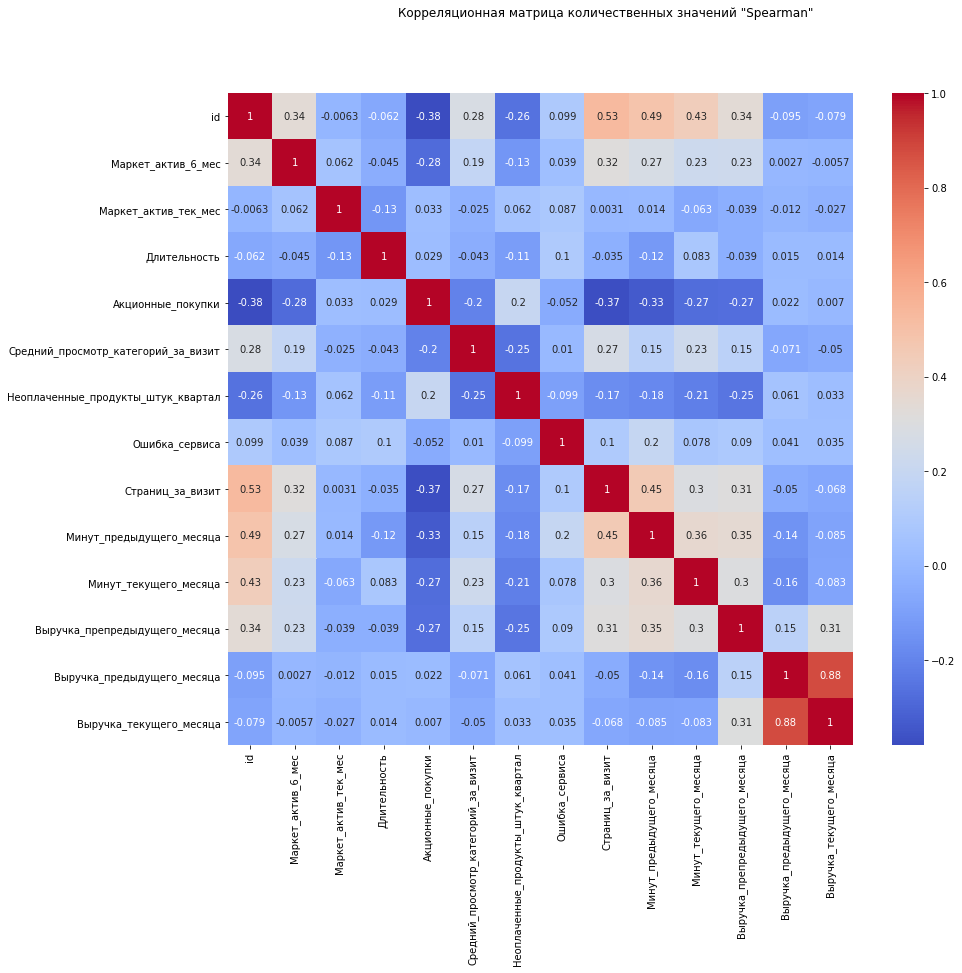

In [ ]:
fig, ax = plt.subplots(figsize=(14, 12))
plt.suptitle('Корреляционная матрица количественных значений "Spearman"')
sns.heatmap(df.drop('id', axis=1).corr(method='spearman'), annot=True, cmap='coolwarm');

In [ ]:
interval_cols = [
    'Маркет_актив_6_мес',
    'Длительность',
    'Акционные_покупки',
    'Выручка_препредыдущего_месяца',
    'Выручка_предыдущего_месяца',
    'Выручка_текущего_месяца'
]

<AxesSubplot:>

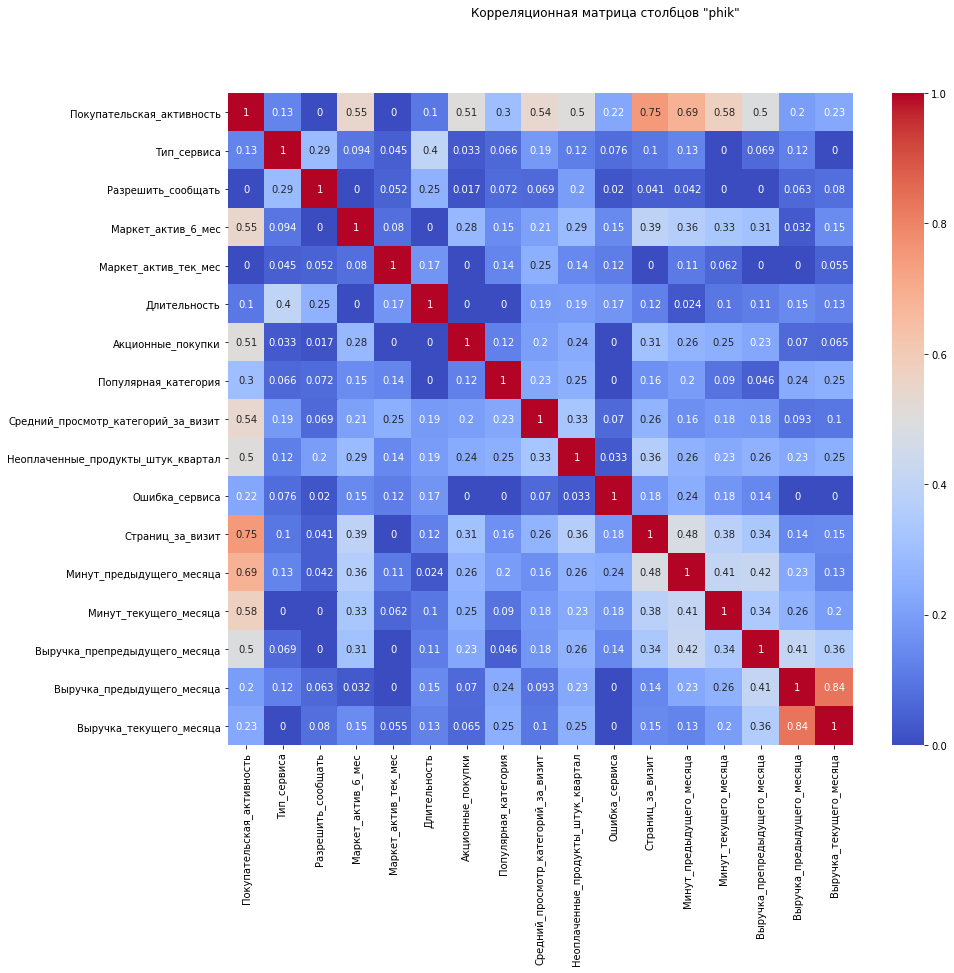

In [ ]:
fig, ax = plt.subplots(figsize=(14, 12))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm')
plt.show()

<div class="alert alert-info">
Наблюдается умеренная корреляция между признаками, однако мультиколлинеарности нет. Соответственно, можно спокойно переходить к обучению модели и не учитывать мультиколлинеарности.
</div>

## Использование пайплайнов

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = df.drop(['Покупательская_активность', 'id'], axis=1)
y = df['Покупательская_активность']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y
)


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test) 

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((972, 16), (325, 16), (972,), (325,))

In [ ]:
# создаём списки с названиями признаков
ohe_columns = ['Популярная_категория']
ord_columns = ['Тип_сервиса', 'Разрешить_сообщать']

In [ ]:
num_columns = ['Выручка_препредыдущего_месяца',       
               'Выручка_предыдущего_месяца',          
               'Выручка_текущего_месяца',             
               'Минут_предыдущего_месяца',            
               'Минут_текущего_месяца',               
               'Маркет_актив_6_мес',                  
               'Маркет_актив_тек_мес',                
               'Длительность',                        
               'Акционные_покупки',                   
               'Средний_просмотр_категорий_за_визит', 
               'Неоплаченные_продукты_штук_квартал',  
               'Ошибка_сервиса',                      
               'Страниц_за_визит'                     
]

In [ ]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
        )
    ]
)


In [ ]:
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)


# Объединяем пайплайны
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [ ]:
# SVC
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE))
])

In [ ]:
param_grid = [
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'preprocessor__ord': [ord_pipe, ohe_pipe]
    }
]

randomized_svc = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


In [ ]:
randomized_svc.fit(X_train, y_train)

print('Best model and its parameters:\n\n', randomized_svc.best_estimator_)
print('ROC-AUC score of the best model:', randomized_svc.best_score_)

Best model and its parameters:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                  

In [ ]:
# LogisticRegression
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'preprocessor__ord': [ord_pipe, ohe_pipe]
    }
]

randomized_lr = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_lr.fit(X_train, y_train)

print('Best model and its parameters:\n\n', randomized_lr.best_estimator_)
print ('ROC-AUC score of the best model:', randomized_lr.best_score_)

Best model and its parameters:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                           

In [ ]:
# DecisionTreeClassifier
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 700),
        'models__max_features': range(2, 16),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'preprocessor__ord': [ord_pipe, ohe_pipe]
    }
]

randomized_dtc = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_dtc.fit(X_train, y_train)

print('Best model and its parameters:\n\n', randomized_dtc.best_estimator_)
print ('ROC-AUC score of the best model:', randomized_dtc.best_score_)

Best model and its parameters:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                  

In [ ]:
# KNeighborsClassifier
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'preprocessor__ord': [ord_pipe, ohe_pipe]
        
        
    }
]

randomized_knc = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_knc.fit(X_train, y_train)

print('Best model and its parameters:\n\n', randomized_knc.best_estimator_)
print ('ROC-AUC score of the best model:', randomized_knc.best_score_)

Best model and its parameters:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                  

In [ ]:
best_svc_model = randomized_svc.best_estimator_
y_pred_svc = best_svc_model.predict(X_test)
y_proba_svc = best_svc_model.predict_proba(X_test)[:, 1]

roc_auc_svc = roc_auc_score(y_test, y_proba_svc)

print(f"ROC-AUC score of the best SVC model on test set: {roc_auc_svc}")

,rank_test_score,param_models,mean_test_score,roc_auc_train,params
3,1,"SVC(degree=9, probability=True, random_state=42)",0.914688,0.968951,"{'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', sparse_output=False)), 'preprocessor__num': StandardScaler(), 'models__kernel': 'rbf', 'models__degree': 9, 'models': SVC(degree=9, probability=True, random_state=42)}"
0,1,KNeighborsClassifier(n_neighbors=9),0.905009,0.949413,"{'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', sparse_output=False)), 'preprocessor__num': RobustScaler(), 'models__n_neighbors': 9, 'models': KNeighborsClassifier(n_neighbors=9)}"
2,1,"LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')",0.898449,0.908064,"{'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['стандарт', 'премиум']], handle_unknown='use_encoded_value', unknown_value=nan), SimpleImputer(strategy='most_frequent')), 'preprocessor__num': MinMaxScaler(), 'models__C': 2, 'models': LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')}"
1,1,"DecisionTreeClassifier(max_depth=57, max_features=15, random_state=42)",0.816610,1.000000,"{'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', sparse_output=False)), 'preprocessor__num': StandardScaler(), 'models__max_features': 15, 'models__max_depth': 57, 'models': DecisionTreeClassifier(max_depth=57, max_features=15, random_state=42)}"


<div class="alert alert-info">
<b>Оптимальная модель:</b> SVC(degree=9, probability=True, random_state=42)

<b>Подготовка данных:</b>\

- 'preprocessor__ord': SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', sparse=False)\
- 'preprocessor__num': StandardScaler()\
- 'models__kernel': 'rbf'\
- 'models__degree': 9
    
<b>Результаты:</b>

- Метрика на тренировочной выборке: 0.9689511192038426
- ROC-AUC на тестовой выборке: 0.917549350024073
    
    
Модель демонстрирует высокую способность к обучению и точное различение классов, что делает её отличным выбором для данной задачи.
</div>

## Анализ важности признаков

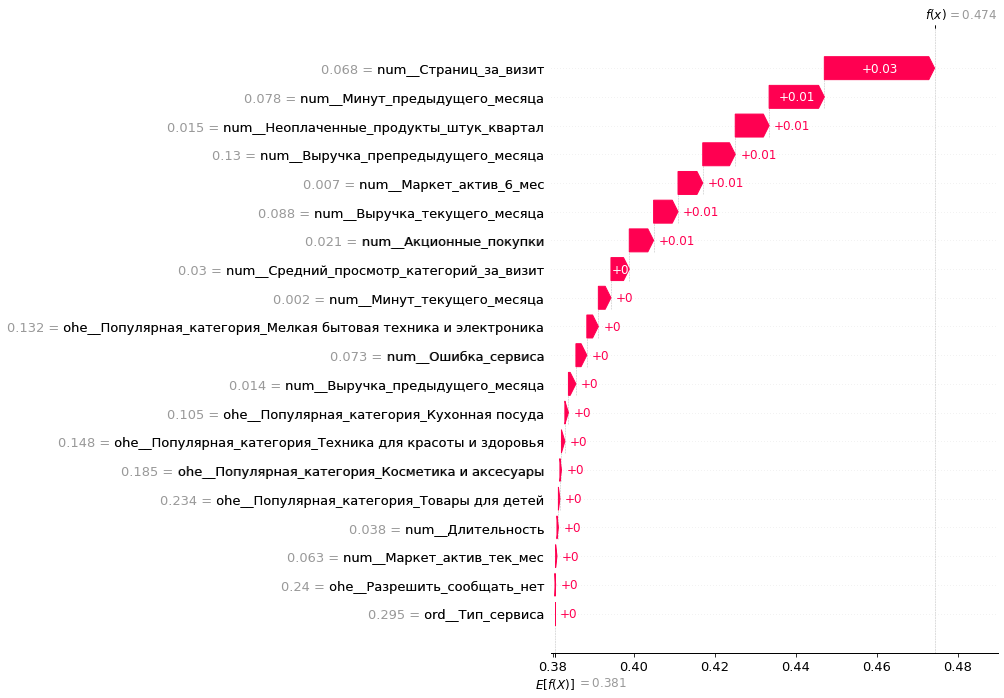

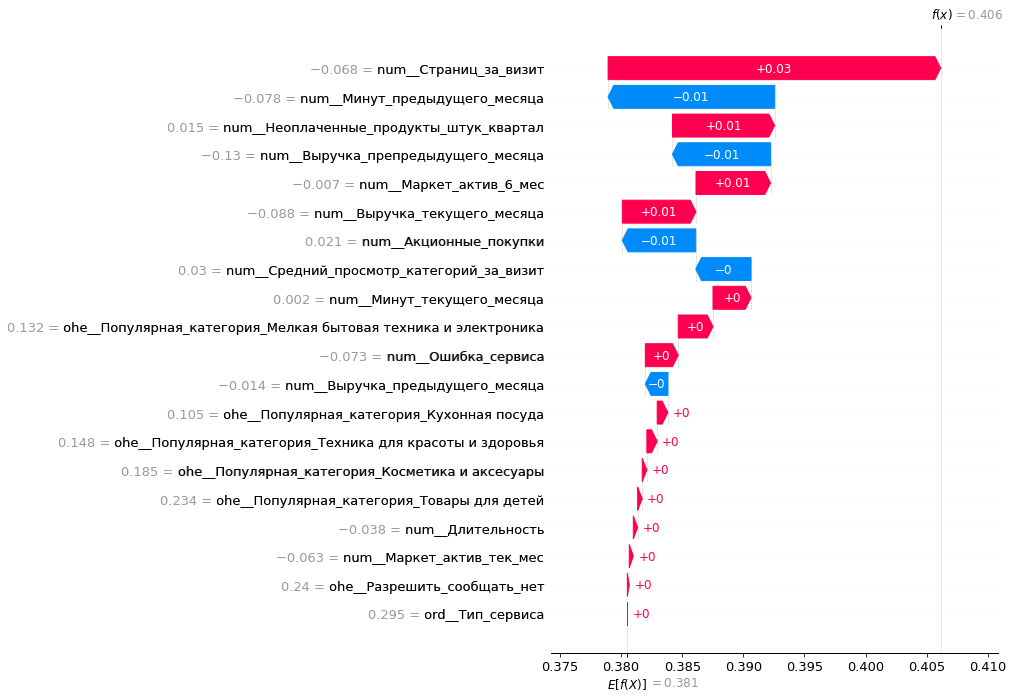

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(degree=5, probability=True, random_state=RANDOM_STATE)
    )
])

pipe_final.fit(X_train, y_train)

# Get the best model
best_model = randomized_dtc.best_estimator_

# Apply transformations to X_train
X_transformed = pd.DataFrame(data_preprocessor.transform(X_test), columns=data_preprocessor.get_feature_names_out())

# Create an explainer using the transformed X_train
explainer = shap.TreeExplainer(best_model.named_steps['models'])

# Calculate SHAP values
shap_values = explainer(X_transformed)

# Visualization of SHAP values
shap_values_sum = 0
for i in range(1, len(shap_values)):
    shap_values_sum += shap_values[i]

    
# Display a waterfall plot of the average SHAP values
plt.ylabel('Average SHAP Value', fontsize=18, fontstyle='italic', fontweight='bold')
shap.plots.waterfall(((shap_values_sum / len(shap_values)).abs[:,1]), max_display=20)

plt.ylabel('Average SHAP Value', fontsize=18, fontstyle='italic', fontweight='bold')
shap.plots.waterfall(((shap_values_sum / len(shap_values))[:,1]), max_display=20)

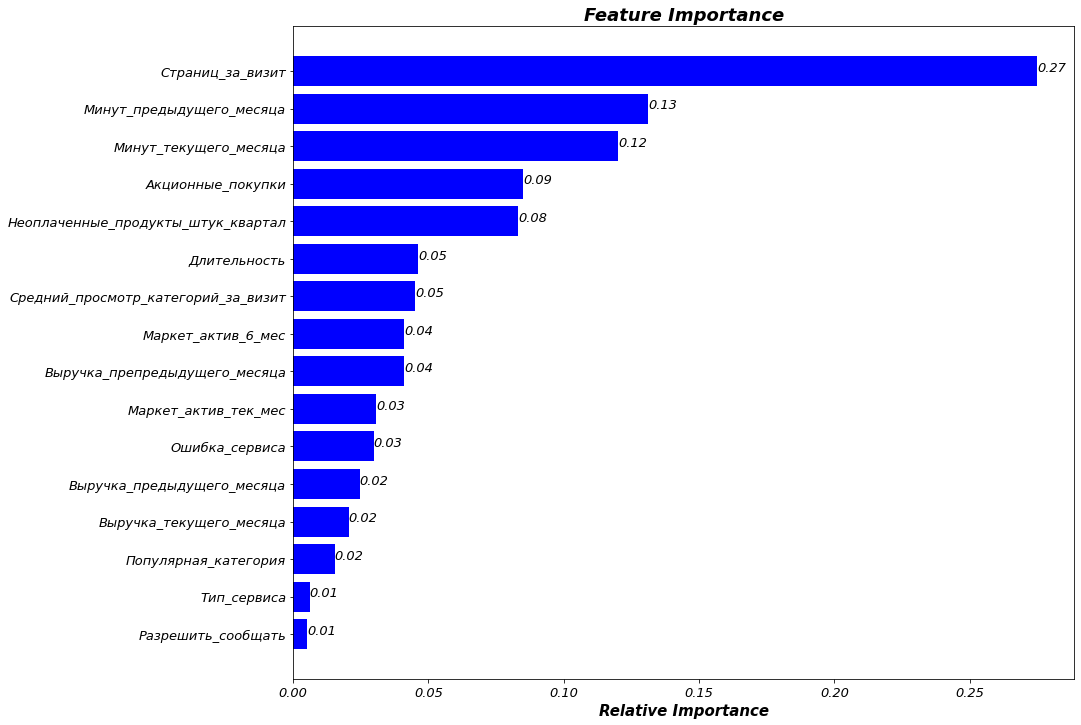

In [ ]:
def plot_permu_impor(model, X_train_data, y_train_data):
    # Compute permutation importance
    perm_importance = permutation_importance(model, X_train_data, y_train_data)
    
    # Normalize the importance values
    perm_importance_normalized = perm_importance.importances_mean / perm_importance.importances_mean.sum()

    # Extract feature names and create an array
    feature_names = X_train_data.columns
    features = np.array(feature_names)

    # Sort the indices of the importance values
    sorted_idx = perm_importance_normalized.argsort()

    # Plot the permutation importance
    plt.figure(figsize=(14,12))
    plt.title('Feature Importance', fontsize=18, fontstyle='italic', fontweight='semibold')
    plt.barh(features[sorted_idx], perm_importance_normalized[sorted_idx], color='b', align='center')
    plt.xlabel('Relative Importance', fontsize=15, fontstyle='italic', fontweight='semibold')
    plt.ylabel('Feature Names', fontsize=18, fontstyle='italic', fontweight='semibold')
    plt.xticks(fontsize=13, fontstyle='italic')
    plt.yticks(fontsize=13, fontstyle='italic')

    # Annotate the bars with importance values
    for index, value in enumerate(perm_importance_normalized[sorted_idx]):
        plt.text(value, index, str(round(value, 2)), fontsize=13, fontstyle='italic')

    plt.show()

# Example usage
plot_permu_impor(pipe_final, X_train, y_train)


<div class="alert alert-info">
<b>Наиболее важные признаки:</b>
    
- Страниц_за_визит
- Минут_текущего_месяца
- Минут_предыдущего_месяца
- Акционные_покупки
- Неоплаченные_продукты_штук_квартал
- Выручка_препредыдущего_месяца
   
    
<b>Наименее важные признаки:</b>
    
- Длительность
- Маркет_актив_6_мес
- Ошибка_сервиса
- Выручка_предыдущего_месяца
- Маркет_актив_тек_мес
- Тип_сервиса
</div>

## Сегментация покупателей

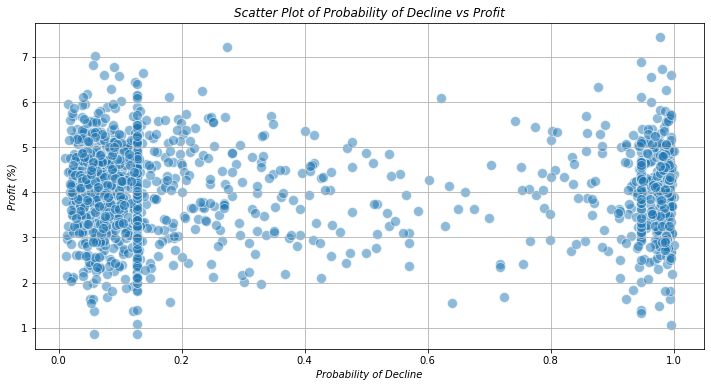

<Figure size 1296x864 with 0 Axes>

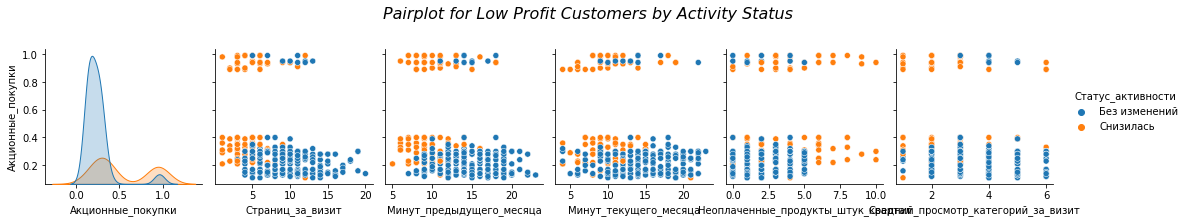

<Figure size 1296x864 with 0 Axes>

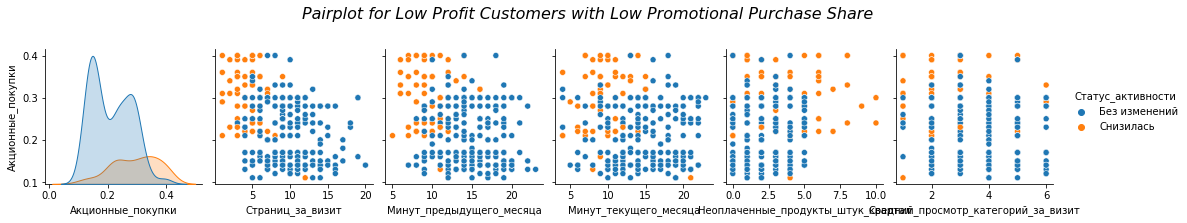

<Figure size 1296x864 with 0 Axes>

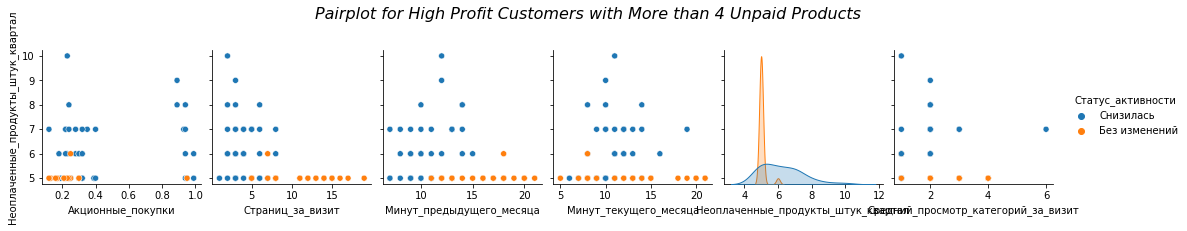

In [ ]:
# Function for calculating predictions
def threshold_predict(X, threshold):
    probabilities = pipe_final.predict_proba(X)
    return (probabilities[:, 1] > threshold).astype(int)

# Applying the predict function and adding new columns to the DataFrame
predicted_labels = threshold_predict(X, threshold=0.5)
X['predicted_label'] = predicted_labels
X['probability'] = pipe_final.predict_proba(X)[:, 1]
X['id'] = df['id']

# Definition of profit category
profit_categories = money['Прибыль'].quantile([0.25, 0.75])
def categorize_profit(profit):
    if profit < profit_categories[0.25]:
        return 'Мало'
    elif profit > profit_categories[0.75]:
        return 'Много'
    return 'Средне'

money['Статус_прибыли'] = money['Прибыль'].apply(categorize_profit)
X = X.merge(money, on='id', how='left', sort=True)

# Visualization of the relationship between the probability of a decrease in activity and profit
plt.figure(figsize=(12, 6))
plt.scatter(X['probability'], X['Прибыль'], alpha=0.5, edgecolors='w', s=100)
plt.title('Scatter Plot of Probability of Decline vs Profit', fontstyle='italic')
plt.xlabel('Probability of Decline', fontstyle='italic')
plt.ylabel('Profit (%)', fontstyle='italic')
plt.grid(True)
plt.show()

# Adding a column for activity reduction categories
X['Статус_активности'] = X['probability'].apply(lambda p: 'Снизилась' if p > 0.5 else 'Без изменений')

# Scatterplot for low profit clients
features = [
    'Акционные_покупки',
    'Страниц_за_визит',
    'Минут_предыдущего_месяца',
    'Минут_текущего_месяца',
    'Неоплаченные_продукты_штук_квартал',
    'Средний_просмотр_категорий_за_визит'
]
target = 'Акционные_покупки'

low_profit_customers = X[X['Статус_прибыли'] == 'Мало']
sns.pairplot(low_profit_customers, hue='Статус_активности', x_vars=features, y_vars=[target])
plt.suptitle("Pairplot for Low Profit Customers by Activity Status", y=1.2, fontsize=16, fontstyle='italic')
plt.show()

# Scatterplot for low profit and low share of promotional purchases clients
filtered_low_profit_customers = low_profit_customers[low_profit_customers['Акционные_покупки'] < 0.5]
sns.pairplot(filtered_low_profit_customers, hue='Статус_активности', x_vars=features, y_vars=[target])
plt.suptitle("Pairplot for Low Profit Customers with Low Promotional Purchase Share", y=1.2, fontsize=16, fontstyle='italic')
plt.show()

# Scatterplot for high profit customers with significant unpaid items
high_profit_customers = X[(X['Статус_прибыли'] == 'Много') & (X['Неоплаченные_продукты_штук_квартал'] > 4)]
sns.pairplot(high_profit_customers, hue='Статус_активности', x_vars=features, y_vars=['Неоплаченные_продукты_штук_квартал'])
plt.suptitle("Pairplot for High Profit Customers with More than 4 Unpaid Products", y=1.2, fontsize=16, fontstyle='italic')
plt.show()

<div class="alert alert-info">
<b>Наблюдается значительное снижение активности покупателей, особенно у тех, у кого доля акционных покупок близка к 50%. Это может указывать на сокращение акций и рекламных предложений.

Рекомендации:</b>

- Создать отдельную группу для этих клиентов.
- Усилить предложения акционных товаров и увеличить количество рекламных кампаний.
- Поощрять клиентов просматривать больше страниц на сайте: активность сохраняется при просмотре более 6 страниц.
- Увеличение числа просмотренных страниц также ведет к более длительному пребыванию на сайте. При пребывании на сайте более 10 - минут вероятность сохранения активности возрастает.
- Информировать клиентов о неоплаченных товарах в корзине (более 6), чтобы мотивировать их завершить покупки.
   
    
<b>Наблюдается значительное снижение покупательской активности у клиентов с высокой прибылью и более 4 неоплаченных товаров в корзине
    
Рекомендации:</b>
    
- Создать отдельную группу для этих клиентов.
- Отправлять уведомления, если у них в корзине накопилось более 6 неоплаченных товаров. Это может побудить их вернуться на сайт, что улучшит ключевые показатели и активность.
</div>

## Общий вывод

<div class="alert alert-info">

<b>В качестве наиболее эффективного варианта выбрана модель SVC с параметрами (degree=5, probability=True, random_state=42), использующая RobustScaler для нормализации числовых данных.</b>

Ключевые и менее значимые признаки
<b>Наиболее важные признаки для увеличения покупательской активности (по убыванию значимости):</b>

- Страниц_за_визит
- Минут_текущего_месяца
- Минут_предыдущего_месяца
- Акционные_покупки
- Неоплаченные_продукты_штук_квартал
- Выручка_препредыдущего_месяца
    
<b>Признаки с низкой значимостью, которые можно исключить:</b>

- Длительность
- Маркет_актив6мес
- Ошибка_сервиса
- Выручка_предыдущего_месяца
- Маркет_актив_тек_мес
- Тип_сервиса
    
<b>Сегментация клиентов и рекомендации:</b>
Сегмент с долей акционных товаров менее 50%, в данной группе наблюдается снижение покупательской активности, особенно среди клиентов с долей акционных покупок близкой к 50%. Это может быть связано с уменьшением рекламных акций.

<b>Рекомендации:</b>

- Создать специализированную рабочую группу для этих клиентов.
- Увеличить количество предложений акционных товаров и активизировать рекламные кампании.
- Стимулировать клиентов просматривать больше страниц на сайте, поскольку активность сохраняется при просмотре более 6 страниц.
- Увеличение числа просмотренных страниц приводит к большему времени на сайте, а пребывание более 10 минут способствует повышению активности.
    
У сегмента с высокой прибыльностью и более 4 неоплаченных товаров в корзине также отмечается значительное снижение покупательской активности.
</div>